In [3]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
import string
import nltk
import pickle
from flask import Flask, request, render_template

# Download the stopwords dataset
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laasy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
#LOAD AND EXPLORE DATASET
# Load the dataset
data = pd.read_csv(r"C:\Users\laasy\Downloads\sms+spam+collection\SMSSpamCollection", 
                   sep='\t', header=None, names=['label', 'text'], on_bad_lines='skip')

# Display the first few rows
print(data.head())

# Check for null values
print(data.isnull().sum())


  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
label    0
text     0
dtype: int64


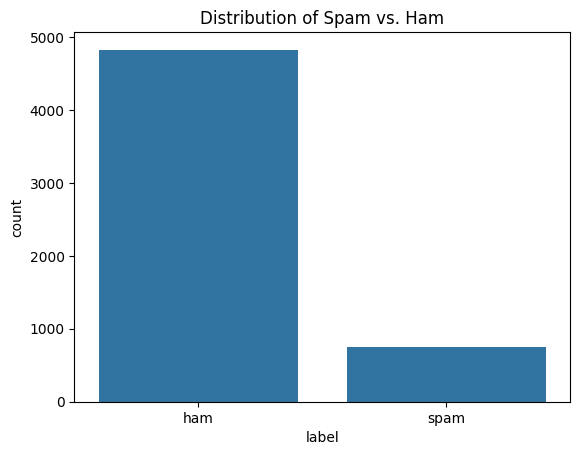

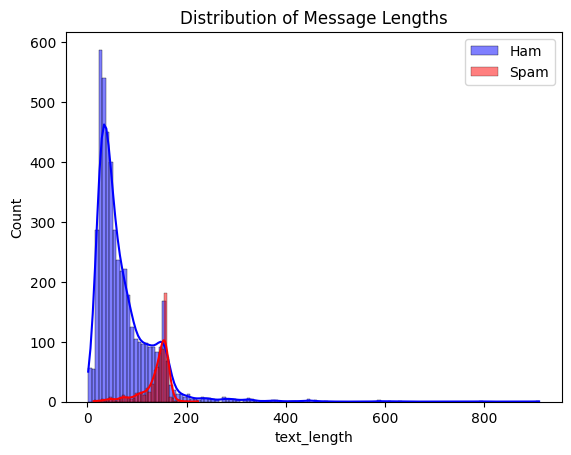

In [5]:
#EDA
# Visualize the distribution of spam vs. ham
sns.countplot(x='label', data=data)
plt.title('Distribution of Spam vs. Ham')
plt.show()

# Display the length of messages
data['text_length'] = data['text'].apply(len)
sns.histplot(data[data['label'] == 'ham']['text_length'], color='blue', label='Ham', kde=True)
sns.histplot(data[data['label'] == 'spam']['text_length'], color='red', label='Spam', kde=True)
plt.legend()
plt.title('Distribution of Message Lengths')
plt.show()


In [6]:
#TEXT PRE-PROCESSING
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    stop_words = stopwords.words('english')
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

data['text'] = data['text'].apply(preprocess_text)


In [7]:
#FEATURE EXTRACTION
# Convert labels to binary values: 'spam' to 1 and 'ham' (non-spam) to 0
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Transform the text data to feature vectors
X = vectorizer.fit_transform(data['text'])
y = data['label']


In [8]:
#SPLIT THE DATA INTO TRAINING AND TESTING SETS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
#MODEL BUILDING
# Initialize the Multinomial Naive Bayes classifier
model = MultinomialNB()

# Train the model
model.fit(X_train, y_train)


MultinomialNB()

Accuracy: 0.97
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       1.00      0.78      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



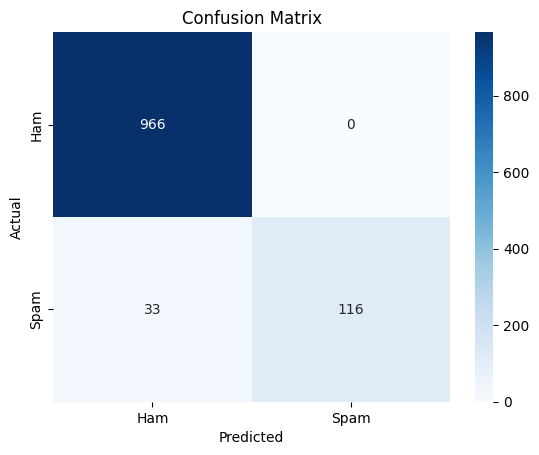

In [10]:
#MODEL EVALUATION
# Predict the labels for the test set
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print the classification report
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [11]:
#MODEL ENHANCEMENT
# Define parameter grid
param_grid = {'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]}

# Initialize GridSearchCV
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')

# Train the model with different hyperparameters
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Cross-validation Score: {best_score:.2f}')


Best Parameters: {'alpha': 0.1}
Best Cross-validation Score: 0.98


In [12]:
#SAVE MODELS
# Save the trained model and the vectorizer
with open('spam_classifier.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)
